# Generating and modeling sequences with LSTM + Mixture Density Networks

## 1- Synthetic Data Generation with a Gaussian Linear Dynamical System with two latent dimensions

AIn this section we will construct a Gaussian Linear State Space Model with latent variables and generate some data with it. The data will be used to train and understand the predictive and generative power of different models. 

In [4]:
# importing some useful libraries

# torch is the Linear Algebra / Neural Networks library we will use in this project.
import torch 

# torch.nn is a module that implements varios useful functions and functors to implement flexible and highly
# customized neural networks. We will use nn to define neural network modules, different kinds of layers and
# diffrent loss functions
import torch.nn as nn

# torch.nn.functional implements a large variety of activation functions and functional forms of different
# neural network layers. Here we will use it for activation functions.
import torch.nn.functional as F

# torch.optim implements many loss functions
import torch.optim as optim

# usuall scientific python stuff
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr

# PyLDS is a Python library for gaussian linear dynamical systems (GLDS) PyLDS also implements
# various methods to perform bayesian inference on GLDSs.DefaultLDS (see the cell below) implements a 
# general purpose linear dynamical system with gaussian noise
from pylds.models import DefaultLDS

# Seeding the random number generators for reproducible results
npr.seed(0)
torch.manual_seed(1)
torch.cuda.manual_seed_all(2)

# checking whether a CUDA-enabled GPU is available and in case it is, we will use it to speed up our training
# and generation programs
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Let's define an LDS and generate some synthetic data
from exam description:
"A toy dataset generated from an LDS.  It should have something like 10 observed states, 100 timesteps, 2 latent dimensions, and 200 instances.  I.e. the entire training set should be 200x10x100"

In [5]:
TIMESTEPS = 300 # number of steps in time
INSTS = 200 # batch-size or the number of instances
DOBS = 10 # number of observable variables
DLAT = 2 # number of hidden variabkes (latent states)

def simple_lds(d_observed=DOBS,d_latent=DLAT,d_input=-1,timesteps=TIMESTEPS,insts=INSTS):
    ## d_observed : dimensionality of observed data
    ## d_latent : dimensionality of latent states
    ## d_input : dimensionality of input data. For d_input=-1 a model with no input is generated
    ## timesteps: number of simulated timesteps
    ## insts: number of instances

    ## instantiating an lds with a random rotational dynamics matrix
    
    if d_input == -1 :
        lds_model = DefaultLDS(d_observed,d_latent,0)
        input_data = None
    else:
        lds_model = DefaultLDS(d_observed,d_latent,d_input)
        input_data = npr.randn(insts,timesteps,d_input)
    
    # initializing the output matrices:
    training_set = np.zeros((insts, timesteps, d_observed))
    latent_states= np.zeros((insts, timesteps, d_latent))
    
    # running the model and generating data
    for i in range(insts):
        training_set[i,:,:], latent_states[i,:,:] = lds_model.generate(timesteps, inputs=input_data)
    return training_set, latent_states, lds_model
    

In [6]:
# Instantiating a Model and Generating Data
ts,ls,mdl = simple_lds()

### Let's have a look at our model and our data
The model is formulated as:

$x_0 \sim \mathcal{N}(\mu_{\text{init}},\sigma_{\text{init}})$

$x_{t+1} \sim \mathcal{N}(\boldsymbol{A} x_{t}+\boldsymbol{B} u_{t},\sigma_{\text{state}})$

$y_{t}  \sim \mathcal{N}(\boldsymbol{C} x_{t}+\boldsymbol{D} u_{t},\sigma_{\text{obs}})$

In [7]:
# mu_init , sigma_init
print("mu_init:\n",mdl.mu_init,"\nsigma_init:\n",mdl.sigma_init)

mu_init:
 [0. 0.] 
sigma_init:
 [[1. 0.]
 [0. 1.]]


In [8]:
# A , B, sigma_state
print("A:\n",mdl.A,"\nB (since we don't have any input):\n",mdl.B,"\nsigma_state:\n",mdl.sigma_states)

A:
 [[ 0.61017762  0.77960456]
 [-0.77960456  0.61017762]] 
B (since we don't have any input):
 [] 
sigma_state:
 [[0.1 0. ]
 [0.  0.1]]


In [9]:
# C , D, sigma_obs
print("C:\n",mdl.C,"\nD (since we don't have any input):\n",mdl.D,"\nsigma_obs:\n",mdl.sigma_obs)

C:
 [[-0.87736332 -1.6210875 ]
 [-0.581673   -0.53783395]
 [-1.55602368 -0.05446484]
 [-1.81127879 -0.63117522]
 [-0.92815918  1.49072192]
 [ 0.19549934 -0.47160433]
 [ 1.81235465 -2.29413748]
 [ 0.65120935 -1.13049645]
 [-0.77734666  1.11593845]
 [ 1.33945302 -1.76743365]] 
D (since we don't have any input):
 [] 
sigma_obs:
 [[0.1 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.1 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.1 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.1 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.1 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.1 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1]]


### Plotting some instances of generated data
Note that the generated signals have an oscilatory behavior when seen locally but looking at the longer sequences, the global activity does not seem to be periodic. The reason is the hidden dynamics of the model.  

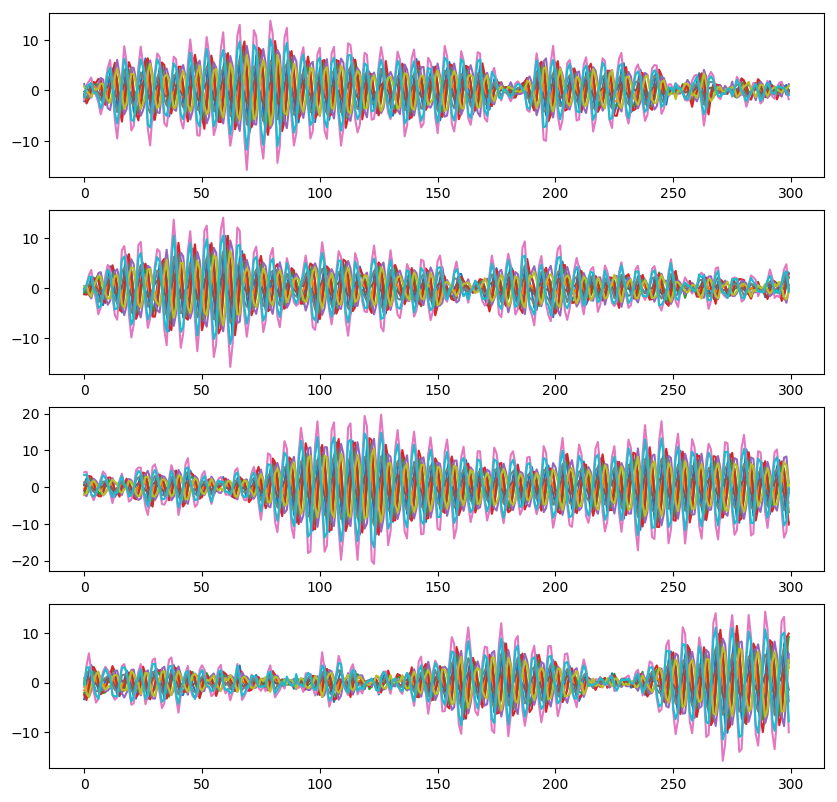

In [7]:
fig = plt.figure(figsize=(10, 10), dpi=100)

ax1 = fig.add_subplot(411)
ax1.plot(ts[0,:,:])

ax2 = fig.add_subplot(412)
ax2.plot(ts[50,:,:])

ax3 = fig.add_subplot(413)
ax3.plot(ts[100,:,:])

ax4 = fig.add_subplot(414)
ax4.plot(ts[199,:,:])

fig = plt.gcf()


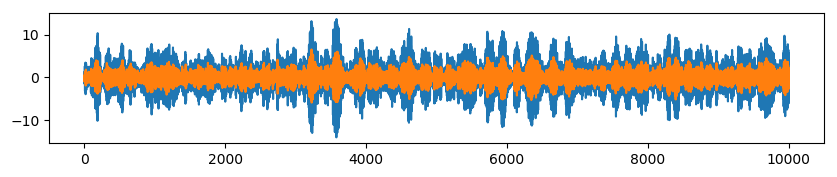

In [31]:
# Let's generate a long sequence
ts_long,ls_long,mdl_long = simple_lds(d_observed=DOBS,d_latent=DLAT,d_input=-1,timesteps=10000,insts=1)

fig = plt.figure(figsize=(10, 10), dpi=100)

ax1 = fig.add_subplot(511)
ax1.plot(ts_long[0,:,1:3])
fig = plt.gcf()

In [32]:
# save the data
torch.save(ts, open('LDS_Toy_Data.pt', 'wb'))

## 2- Fitting a Gaussian LDS with no latent dimensions to the data

In this section we will try to fit a GLSSM with no latent variables to our data.
The model is formulated as:

$x_0 \sim \mathcal{N}(\mu_{\text{init}},\sigma_{\text{init}})$

$x_{t+1} \sim \mathcal{N}(\boldsymbol{A} x_{t},\sigma_{\text{state}})$

Given the gaussian noise, the Maximum Likelihood estimate for $\boldsymbol{A}$ can be obtained by minimizing the $L_{2}$ norm

In [39]:
# nn.Module is the Base class for all neural network modules. It can contain other modules as well
class LinearModel(nn.Module):
    # here we initialize the parameters of the network. Since we are implementing a GLSSM, we don't
    # need to implement a "neural network". We are basically performing simple linear regression. 
    # It is convenient to use PyTorch's nn.Module since it will allow us to implicitely define and initialize
    # all the parameters of the model and PyTorch will handle the autograd mechanics as well as GPU parallelization
    # for us.
    def __init__(self,d_obs):
        super(LinearModel, self).__init__()
        # Let's define and initialize the A matrix as defined in the markdown. We use the PyTorch Linear Model
        # nn.Linear(d_in,d_out) is a functor that maps from R^{d_in} to R^{d_out}
        self.A = nn.Linear(d_obs,d_obs,bias=False) # note that our model should not have a bias parameter
    def forward(self,input_):
        # forward method is the core action of the model. PyTorch will take care of the backward action as
        # long as all the used functions in the forward method have proper backward implementations.
        return self.A(input_)

    
    
# initialize the model with DOBS = 10 dimensions    
model = LinearModel(DOBS)

# since we have gaussian noise, minimizing MSE should work. So we define the loss function using nn.MSELoss
criterion = nn.MSELoss()

# PyTorch magic to run the model on GPU
model.to(device)

# our data is coming from numpy tensors so it will be of the type double. PyTorch will initially consider 
# float tensors. So we should tell it to expect doubles.
model.double()

LinearModel(
  (A): Linear(in_features=10, out_features=10, bias=False)
)

In [40]:
#prepare data in the right format for learning:
tsr = ts.view() # a trcik to clone an ndarray in numpy
tsr = tsr.reshape(INSTS*TIMESTEPS,DOBS) # flatten the data in the batch dimension

inds= np.arange(INSTS*TIMESTEPS) # all the indices 
# we have to make sure that X's and Y's are chosen from consecutive samples
# making sure X's and Y's are from the same instance (same latent dimensions)
x_mask = (inds+1)%TIMESTEPS!=0
x_inds = inds[x_mask]
y_inds = x_inds + 1

# the entire dataset
x_all = tsr[x_inds]
y_all = tsr[y_inds]

# choosing a 3rd of the dataset for testing
test_inds=npr.choice(x_all.shape[0], np.int(x_all.shape[0]/3), replace=False)
train_inds = np.setdiff1d(np.arange(x_all.shape[0]), test_inds)
np.random.shuffle(train_inds)

# final test and train datasets
x_train = torch.from_numpy(x_all[train_inds])
x_test = torch.from_numpy(x_all[test_inds])
y_train = torch.from_numpy(y_all[train_inds])
y_test = torch.from_numpy(y_all[test_inds])

In [41]:
# training the model

# our optimizer is going to be Adam with the learning rate of 0.01
# model.parameters() exposes the parameters of the model. In our case model.oarameters() will give the entries of A
optimizer = optim.Adam(model.parameters(), lr=0.01) 

# the number of epochs 
num_epochs = 200

# tracking losses to visualize the training process
train_losses=np.zeros(num_epochs)
test_losses=np.zeros(num_epochs)

# the train loop
for epoch in range(num_epochs):
    inputs = x_train.to(device)
    target = y_train.to(device)

    # forward
    out = model(inputs)
    loss = criterion(out, target)
    train_losses[epoch]=loss.data.item()
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        test_inputs = Variable(x_test).to(device)
        test_target = Variable(y_test).to(device)
        test_out = model(test_inputs)
        test_loss = criterion(test_out, test_target)
        test_losses[epoch]=test_loss.data.item()
        if (epoch+1) % 50 == 0:
            print('Epoch[{}/{}], train_loss: {:.6f}---test_loss: {:.6f}'
              .format(epoch+1, num_epochs, loss.data.item(),test_loss.data.item()))


Epoch[50/200], train_loss: 0.966206---test_loss: 0.929062
Epoch[100/200], train_loss: 0.466822---test_loss: 0.463094
Epoch[150/200], train_loss: 0.461776---test_loss: 0.458185
Epoch[200/200], train_loss: 0.458840---test_loss: 0.455236


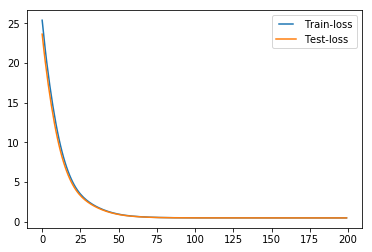

In [42]:
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(train_losses, label='Train-loss')
line2, = plt.plot(test_losses, label='Test-loss')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})

### Generating Data with the fitted model

In [46]:
def linear_generator(net,init,length):
    outs=[init]
    out = model(init.to(device))
    outs.append(out)
    for i in range(length-2):
        # here we pass the last output as the input of the network. 
        out = net(out)
        outs.append(out)
    outs = [out.cpu() for out in outs]
    return torch.stack(outs,0).detach().numpy()

As we see here, the learned model behaves like a simple damped oscilator. It has not learned anything about the temporal structure of the data. Indeed this was quite predictable since the model has no hidden states so it has no way to use it's previous outputs to change its behavior. The entire structure of the data is modeled in the entries of $\boldsymbol{A}$.

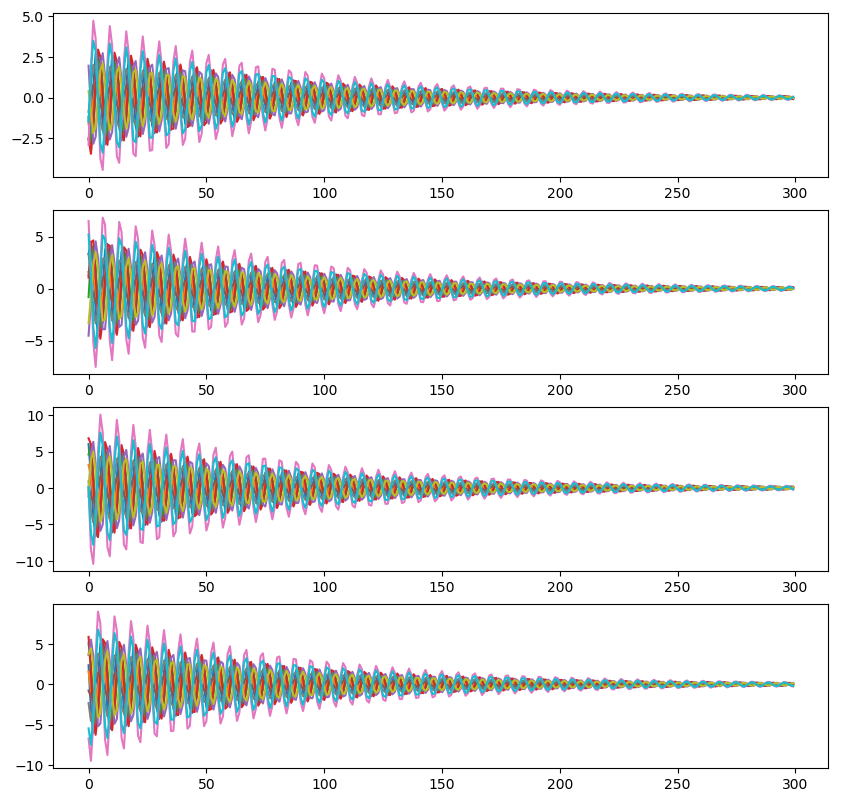

In [45]:
fig = plt.figure(figsize=(10, 10), dpi=100)

ax1 = fig.add_subplot(411)
ax1.plot(linear_generator(model,x_test[0],TIMESTEPS))

ax2 = fig.add_subplot(412)
ax2.plot(linear_generator(model,x_test[1000],TIMESTEPS))

ax3 = fig.add_subplot(413)
ax3.plot(linear_generator(model,x_test[2000],TIMESTEPS))

ax4 = fig.add_subplot(414)
ax4.plot(linear_generator(model,x_test[3000],TIMESTEPS))

fig = plt.gcf()


### Experiment with a deeper model that takes 3 consecutive samples and tries to predict the next sample
Can we fix the situation in the section above? What if we use a model that looks into more than one sample of data and tries to predict the next sample? What if we increase the depth of the model?

Here we implement a feed-forward deep model to run our experiment.

In [59]:
#define the model, the loss function and the optimizer
class DeepModelWithMemory(nn.Module):
    def __init__(self,d_obs):
        super(DeepModelWithMemory, self).__init__()
        # the model takes a concatenated vector made of 3 samples (d_in = 3*d_obs)
        self.A = nn.Linear(3*d_obs,d_obs, bias=False) 
        # a bunch of layers
        self.B = nn.Linear(d_obs,d_obs, bias=False)
        self.C = nn.Linear(d_obs,d_obs, bias=False)
        self.D = nn.Linear(d_obs,d_obs, bias=False)
    def forward(self,input_):
        # since we are not using bias, we use Tanh activation layer (instead of the usual ReLu) so that our 
        # model can produce negative values and oscilatory behavior
        x = F.tanh(self.A(input_))
        x = F.tanh(self.B(x))
        x = F.tanh(self.C(x))
        return self.D(x)

# initiating the model
model2 = DeepModelWithMemory(DOBS)
model2.to(device)
model2.double()

DeepModelWithMemory(
  (A): Linear(in_features=30, out_features=10, bias=False)
  (B): Linear(in_features=10, out_features=10, bias=False)
  (C): Linear(in_features=10, out_features=10, bias=False)
  (D): Linear(in_features=10, out_features=10, bias=False)
)

In [60]:
#prepare data in the right format for learning:
tsr = ts.view()
tsr = tsr.reshape(INSTS*TIMESTEPS,DOBS)
inds= np.arange(INSTS*TIMESTEPS)
# we have to make sure that X's and Y's are chosen from consecutive samples
# making sure X's and Y's are from the same instance (same latent dimensions)
x_mask1 = (inds+1)%TIMESTEPS!=0
x_mask2 = (inds+2)%TIMESTEPS!=0
x_mask3 = (inds+3)%TIMESTEPS!=0
x_mask = [(x_mask1[i] and x_mask2[i]) and x_mask3[i] for i in range(len(inds))]
x_inds = inds[x_mask]
y_inds = x_inds + 3
y_all = tsr[y_inds]
xx_all = np.zeros((y_all.shape[0],3*DOBS))
for i,ind in enumerate(x_inds):
    x1 = tsr[ind]
    x2 = tsr[ind+1]
    x3 = tsr[ind+2]
    x = np.append(x1,x2)
    xx_all[i] = np.append(x,x3)
test_inds=npr.choice(xx_all.shape[0], np.int(xx_all.shape[0]/3), replace=False)
train_inds = np.setdiff1d(np.arange(xx_all.shape[0]), test_inds)
np.random.shuffle(train_inds)
# final test and train datasets
xx_train = torch.from_numpy(xx_all[train_inds])
xx_test = torch.from_numpy(xx_all[test_inds])
y_train = torch.from_numpy(y_all[train_inds])
y_test = torch.from_numpy(y_all[test_inds])

In [61]:
criterion = nn.MSELoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.005)
num_epochs = 2000
train_losses=np.zeros(num_epochs)
test_losses=np.zeros(num_epochs)

for epoch in range(num_epochs):
    inputs = Variable(xx_train).to(device)
    target = Variable(y_train).to(device)

    # forward
    out = model2(inputs)
    loss2 = criterion(out, target)
    train_losses[epoch]=loss2.data.item()
    # backward
    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step()
    with torch.no_grad():
        test_inputs = Variable(xx_test).to(device)
        test_target = Variable(y_test).to(device)
        test_out = model2(test_inputs)
        test_loss = criterion(test_out, test_target)
        test_losses[epoch]=test_loss.data.item()
        if (epoch+1) % 500 == 0:
            print('Epoch[{}/{}], train_loss: {:.6f}---test_loss: {:.6f}'
              .format(epoch+1, num_epochs, loss2.data.item(),test_loss.data.item()))


Epoch[500/2000], train_loss: 0.760324---test_loss: 0.776664
Epoch[1000/2000], train_loss: 0.537674---test_loss: 0.545938
Epoch[1500/2000], train_loss: 0.475001---test_loss: 0.479580
Epoch[2000/2000], train_loss: 0.510032---test_loss: 0.469353


In [62]:
def generator_memory(net,init,length):
    init1 = init[:DOBS]
    init2 = init[DOBS:2*DOBS]
    init3 = init[2*DOBS:3*DOBS]
    outs=[init1,init2,init3]
    out = net(Variable(init).to(device))
    outs.append(out)
    for i in range(length-2):
        input_ = torch.cat((outs[-3].to(device),outs[-2].to(device),out))
        out = net(Variable(input_))
        outs.append(out)
    outs = [out.cpu() for out in outs]
    return torch.stack(outs,0).detach().numpy()

### Visualizing some output sequences
First let's generate some sequences starting from different samples of the test data. As we see the model has learned some temporal structure. It's able to switch between two basic modes of high and low amplitude.

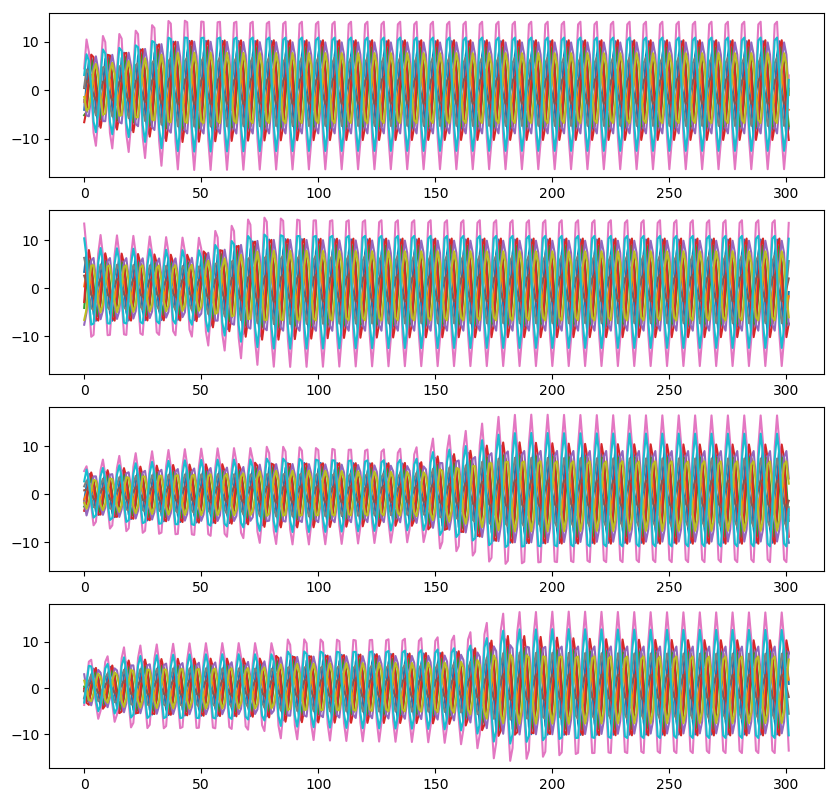

In [63]:
fig = plt.figure(figsize=(10, 10), dpi=100)

ax1 = fig.add_subplot(411)
ax1.plot(generator_memory(model2,xx_test[0],TIMESTEPS))

ax2 = fig.add_subplot(412)
ax2.plot(generator_memory(model2,xx_test[1000],TIMESTEPS))

ax3 = fig.add_subplot(413)
ax3.plot(generator_memory(model2,xx_test[2000],TIMESTEPS))

ax4 = fig.add_subplot(414)
ax4.plot(generator_memory(model2,xx_test[3000],TIMESTEPS))

fig = plt.gcf()


But if we generate a long enough sequence, we'll see that it quickly get's stuck in a fixed-point.

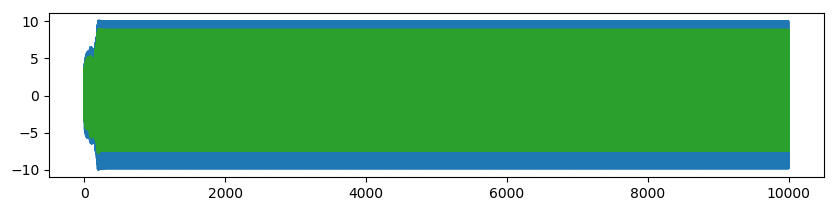

In [69]:
fig = plt.figure(figsize=(10, 10), dpi=100)

ax1 = fig.add_subplot(411)
ax1.plot(generator_memory(model2,xx_test[100],10000)[:,0:3])
fig = plt.gcf()

## 3-Generative LSTM with Mixture Density Network
In this section we will construct a Long-Short-term-Memory Network that parameterise a Gaussian Mixture Model.
This model allows us to learn a complex joint distribution for the data and generate sequences.
The LSTM Network enjoys long temporal dependencies and can potentially model very complex temporal structure in the data

In [73]:
class MDNLSTM(nn.Module):
    def __init__(self, d_obs, d_lat=2, n_gaussians=1, n_layers=1):
        super(MDNLSTM, self).__init__()

        self.d_obs = d_obs
        self.d_lat = d_lat
        
        # this is the number of gaussians we'd use for the mixture density
        self.n_gaussians = n_gaussians 
        
        # LSTMs can be stacked on top of each other, allowing the network to have deeper memory
        # this is the number of stacked LSTMs
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(d_obs, d_lat, n_layers, batch_first=True) #batch_first=True to avoid confusing reshaping
        
        # three fully connected neural networks to learn the means, standard deviations and weights of the mixture model
        # since they get their input from the lstm layers, d_in = d_lat. The output size will be the number of 
        # observed dimensions*the number of gaussians. So they will learn to generate n_gaussian distributions
        # for each observed dimension
        self.fcPi = nn.Linear(d_lat, n_gaussians*d_obs) # mixture weights (not normalized)
        self.fcMu = nn.Linear(d_lat, n_gaussians*d_obs) # mixture means
        self.fcSigma = nn.Linear(d_lat, n_gaussians*d_obs) # log-sigmas ... 
        
        
    def get_mixture_coef(self, y):
        time_steps = y.size(1)
        pi, mu, sigma = self.fcPi(y), self.fcMu(y), self.fcSigma(y)
        
        # format the outputs in a useful way so we can simplify the loss function
        pi = pi.view(-1, time_steps, self.n_gaussians, self.d_obs)
        mu = mu.view(-1, time_steps, self.n_gaussians, self.d_obs)
        sigma = sigma.view(-1, time_steps, self.n_gaussians, self.d_obs)
        
        # The mixture weight outputs are normalised with a softmax function to ensure they form
        # a valid discrete distribution
        pi = F.softmax(pi, 2)
        
        # the exponential function is applied to outputs used as scale parameters (sigmas), which must be positive
        sigma = torch.exp(sigma)
        return pi, mu, sigma
        
        
    def forward(self, x, h):
        # Forward propagate LSTM
        y, (h, c) = self.lstm(x, h)
        pi, mu, sigma = self.get_mixture_coef(y)
        return (pi, mu, sigma), (h, c)
    
    # we will use thismethod to initialize the hidden layers. It's good to build this into the model so we
    # won't need to pass the information of the network in runtime... just cleaner interface and avoiding bugs
    def init_hidden(self, bsz):
        # note that since these initialization tensors are not model parameters, we have to push them to
        # the GPU manually. model.to(device) won't affect these.
        return (torch.zeros(self.n_layers, bsz, self.d_lat).to(device),
                torch.zeros(self.n_layers, bsz, self.d_lat).to(device))

In [74]:
# the function below ensures that we won't underflow when calculating exps of very small numbers for our loss function.
# We implement a weighted version of the log-sum-exp trick. We also handle the possible inf cases to avoide 
# returning nan's. It's sad that PyTorch ignores nan's and doesn't raise an exception. 
def weighted_logsumexp(x,w, dim=None, keepdim=False):
    if dim is None:
        x, dim = x.view(-1), 0
    xm, _ = torch.max(x, dim, keepdim=True) # find the maximum exponent
    
    x = torch.where(
        (xm == float('inf')) | (xm == float('-inf')), # handle inf cases that produce nan's
        xm,
        xm + torch.log(torch.sum(torch.exp(x - xm)*w, dim, keepdim=True))) #log-sum-exp trick
    return x if keepdim else x.squeeze(dim)


# defining the stable loss function:
def mdn_loss_stable(y,pi,mu,sigma):
    # generate torch normal distribution objects from mu's and sigma's
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    # compute the log-likelihood of the target given the parameterized distributions
    m_lp_y = m.log_prob(y)
    # the loss vector is the weighted sum of likelihoods
    loss = -weighted_logsumexp(m_lp_y,pi,dim=2)
    # compute the mean of the loss vector over all observed dimensions
    return loss.mean()

def criterion(y, pi, mu, sigma):
    y = y.unsqueeze(2) # make sure y is in the appropriate shape
    return mdn_loss_stable(y, pi, mu, sigma)

In [75]:
# to detach the hidden state after unrolling and rolling back. In other words, Truncated Backpropagation Through Time
def detach(states):
    return [state.detach() for state in states]

In [133]:
def mndlstm_train(n_layers,d_lat,n_gaussians,epochs):
    # initializing the model
    mdnlstm = MDNLSTM(DOBS, d_lat,n_gaussians=n_gaussians, n_layers=n_layers).to(device)
    # and the optimizer
    optimizer = torch.optim.Adam(mdnlstm.parameters(), lr=lr)

    # I used this part to be able to train on smaller batch sizes. Also to convert our data to float (faster than double)
    z =  torch.from_numpy(ts[:INSTS,:,:]).float().to(device)
    # Train the model
    for epoch in range(epochs):
        # Set initial hidden and cell states
        hidden = mdnlstm.init_hidden(INSTS)

        # we will read the data using a moving window on the dataset. At each step we are taking a seqlen-long 
        # section of the data and try to predict the 1-step shifted vector. Basically we want the network to 
        # learn to generate a future instance
        for i in range(0, z.size(1) - seqlen, seqlen):
            # Get mini-batch inputs and targets
            inputs = z[:, i:i+seqlen, :]
            targets = z[:, (i+1):(i+1)+seqlen, :]

            # Forward pass
            hidden = detach(hidden)
            (pi, mu, sigma), hidden = mdnlstm(inputs, hidden)
            loss = criterion(targets, pi, mu, sigma)

            # Backward and optimize
            mdnlstm.zero_grad()
            loss.backward()
            # clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

        if (epoch+1) % np.int(epochs/5) == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, epochs, loss.item()))
    return mdnlstm

Let's try a few different scenarios. First we will train the network for only 2 latent variables, one layer LSTM and only one gaussian.

In [143]:
seqlen = 150 # length of the unrolling sequence. This can also be variable but we use a fixed moving window

INSTS = 200 # batchsize
DOBS = 10 # number of observed variables
DLAT = 2 # dimensions of the hidden state of the LSTM stack
NL = 1 # depth of the LSTM stack
lr = 0.01 # learning rate
NG = 1 # the simplest case for only one gaussian per dimension. 
epochs = 10000
mdnlstm1 = mndlstm_train(n_layers=NL,d_lat = DLAT, n_gaussians=NL,epochs=epochs)

Epoch [2000/10000], Loss: 1.0644
Epoch [4000/10000], Loss: 0.9368
Epoch [6000/10000], Loss: 0.9393
Epoch [8000/10000], Loss: 0.9293
Epoch [10000/10000], Loss: 0.9251


In [144]:
def lstm_generator(net,init,added_length):
    #x_init = z[0:1, :100, :]
    x = init.clone()
    # y = z[zero:zero+1, one+1:one+2, :]
    hidden = net.init_hidden(1)
    for i in range(added_length):
    #     hidden = detach(hidden)
        (pi, mu, sigma), hidden = net(x, hidden)
        x=torch.cat((x,mu.squeeze(2)[:,-1:,:]),1)
    return x.squeeze(0).detach().cpu().numpy()

In [145]:
#generating sequences conditioned on different lengths of observed data (red)
def viz(model,dataInd =10):
    fig = plt.figure(figsize=(10, 10), dpi=100)
    ax1 = fig.add_subplot(611)
    ax1.plot(lstm_generator(model,z[dataInd:dataInd+1, :1, :],TIMESTEPS-1))
    ax1.plot(z[dataInd:dataInd+1, :1, :].squeeze(0).detach().cpu().numpy(),'r')

    ax2 = fig.add_subplot(612)
    ax2.plot(lstm_generator(model,z[dataInd:dataInd+1, :50, :],TIMESTEPS-50))
    ax2.plot(z[dataInd:dataInd+1, :50, :].squeeze(0).detach().cpu().numpy(),'r')

    ax3 = fig.add_subplot(613)
    ax3.plot(lstm_generator(model,z[dataInd:dataInd+1, :100, :],TIMESTEPS-100))
    ax3.plot(z[dataInd:dataInd+1, :100, :].squeeze(0).detach().cpu().numpy(),'r')

    ax4 = fig.add_subplot(614)
    ax4.plot(lstm_generator(model,z[dataInd:dataInd+1, :150, :],TIMESTEPS-150))
    ax4.plot(z[dataInd:dataInd+1, :150, :].squeeze(0).detach().cpu().numpy(),'r')

    ax5 = fig.add_subplot(615)
    ax5.plot(lstm_generator(model,z[dataInd:dataInd+1, :200, :],TIMESTEPS-200))
    ax5.plot(z[dataInd:dataInd+1, :200, :].squeeze(0).detach().cpu().numpy(),'r')

    ax6 = fig.add_subplot(616)
    ax6.plot(lstm_generator(model,z[dataInd:dataInd+1, :250, :],TIMESTEPS-250))
    ax6.plot(z[dataInd:dataInd+1, :250, :].squeeze(0).detach().cpu().numpy(),'r')

    fig = plt.gcf()

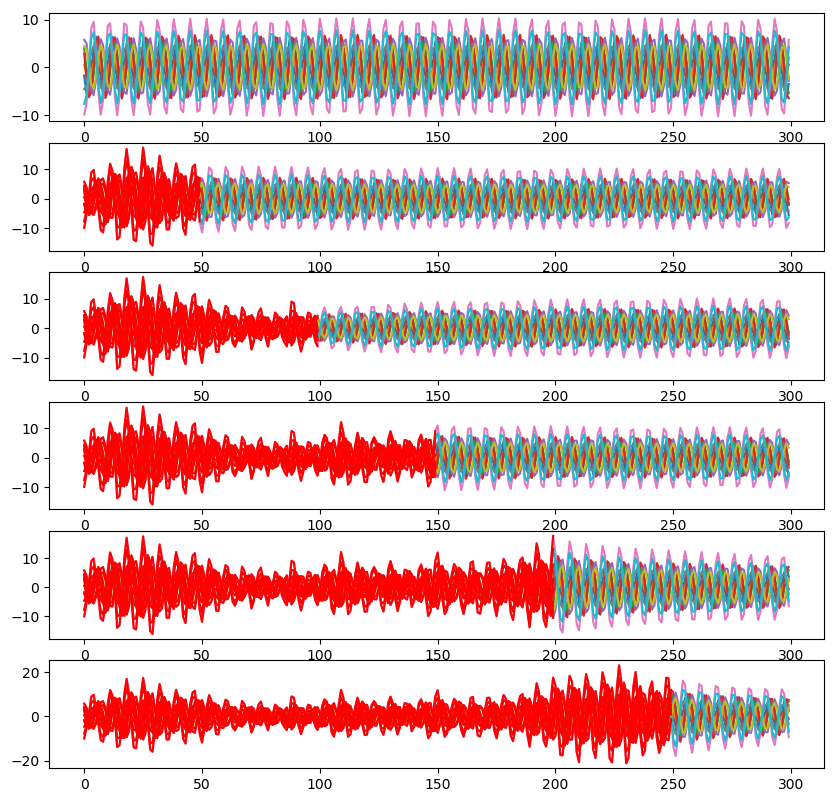

In [146]:
viz(mdnlstm1)

Epoch [2000/10000], Loss: 0.6449
Epoch [4000/10000], Loss: 0.4625
Epoch [6000/10000], Loss: 0.4595
Epoch [8000/10000], Loss: 0.4873
Epoch [10000/10000], Loss: 0.4078


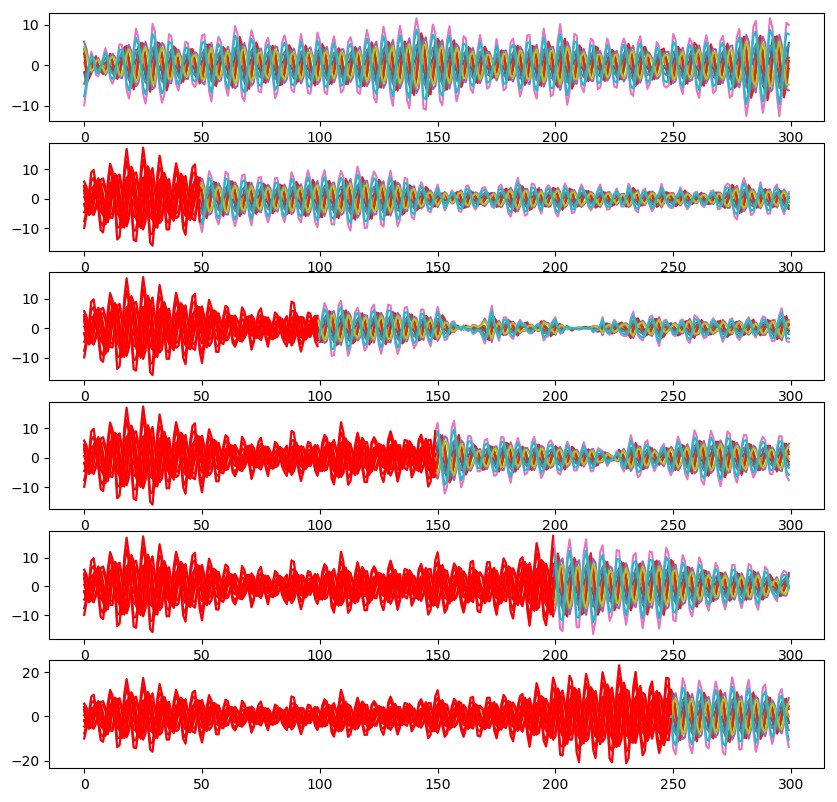

In [151]:
lr = 0.01
mdnlstm2 = mndlstm_train(n_layers=1,d_lat = 100, n_gaussians=NL,epochs=epochs)
viz(mdnlstm2)

Epoch [4000/20000], Loss: 2.2233
Epoch [8000/20000], Loss: 1.4100
Epoch [12000/20000], Loss: 1.0815
Epoch [16000/20000], Loss: 1.0421
Epoch [20000/20000], Loss: 1.0310


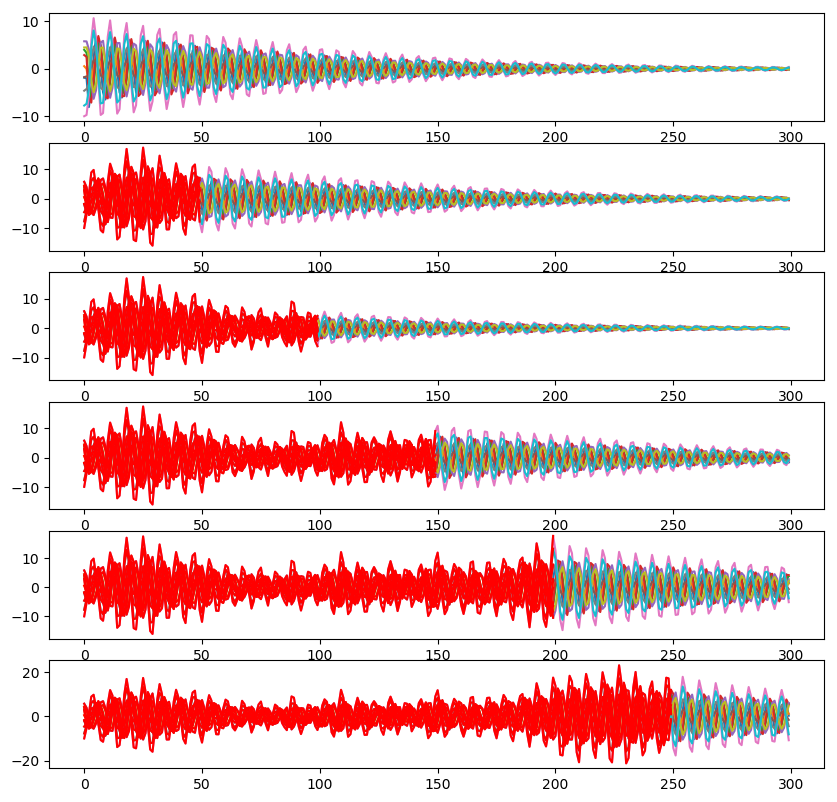

In [159]:
lr = 0.001
mdnlstm3 = mndlstm_train(n_layers=10,d_lat = 2, n_gaussians=NL,epochs=20000)
viz(mdnlstm3)

Epoch [4000/20000], Loss: 0.5328
Epoch [8000/20000], Loss: 0.3880
Epoch [12000/20000], Loss: 0.3662
Epoch [16000/20000], Loss: 0.3193
Epoch [20000/20000], Loss: 0.2827


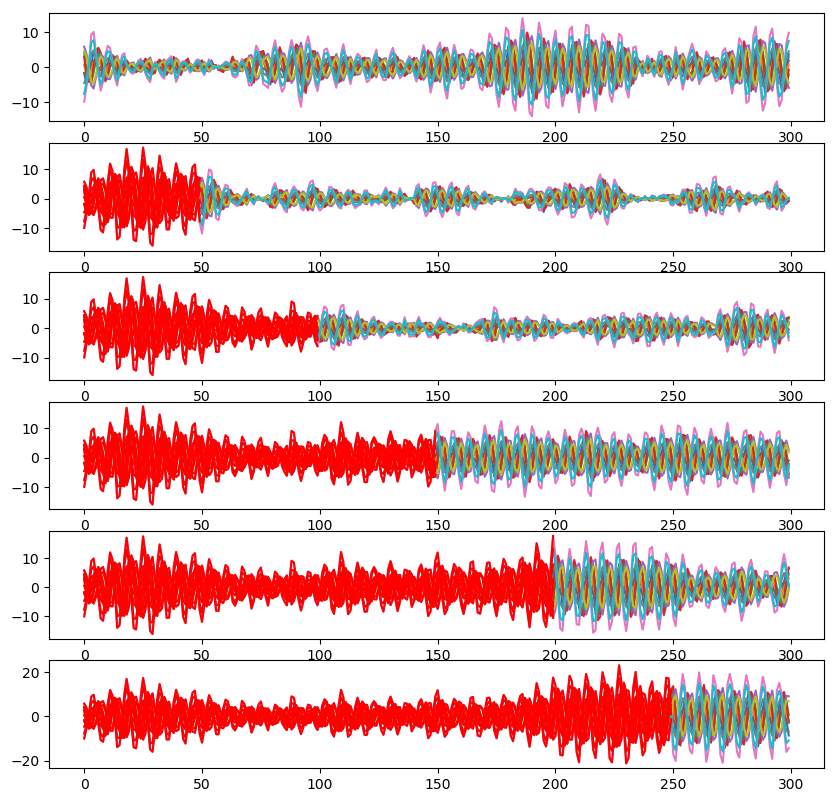

In [158]:
lr = 0.01
mdnlstm4 = mndlstm_train(n_layers=3,d_lat = 50, n_gaussians=NL,epochs=20000)
viz(mdnlstm4)